---

 __curso [Introducción a la programación HPC con Python y sus aplicaciones al campo de proceso de imágenes]([https://ig.conae.unc.edu.ar/introduccion-a-la-programacion-hpc-2025/])__

Simulador de Circuitos Cuánticos, acelerado por MPI y/o GPU. ver [README.md](https://github.com/eterX/CP33simu/blob/main/README.md)

---
# Sección 0 - inicialización


Inicialización de la biblioteca `cp33simu`, el entorno y variables globales.

Validamos que el stack está instalado y funcionando. Como se probó en gColab (cuenta gratuita) con entorno T4, CuPY falló en instalar. Como alternativa se instaló el stack en una portátil con GPU NVDIA GTX 960M (compute capability 5.0). Se muestran resultados abajo.

In [4]:
#Inicialización del entorno y variables globales

%load_ext autoreload
%autoreload 2
import qiskit as qk
import sympy as sp
import cp33simu


# globales (perdón Niklaus) TODO: mandar a archivo de config
num_qubits = 5  #número de qubits a simular
corridas = 30 #corridas del Aer de benchmark
benchmarks_requeridos = {"qiskit-aer":False, "simuMPI":True, "simuGPU":True, "simuGPUbajo":True} #Todo validar claves, o no :)

## verificamos CUDA y cupy
_=list()
_.append(qk.QuantumCircuit(1,0))
_[-1].h(0)
_.append(cp33simu.simuGPU(qc=_[-1]))
try:
    if not _[-1].cupy_installed():
        # hay problemas con Cupy
        raise ImportError("Cupy no está instalado")
    if not _[-1].validate_cupy():
        raise ImportError("Cupy no está funcionando bien")
except ImportError as e:
        print(f"WARN: {e}")
except Exception:
        raise
finally:
    for tmp in _:
        del(tmp) # borro temporales



# para benchmarks
benchmarks_corridos = None
if True in benchmarks_requeridos.values(): #probar esta sintaxis
    print(f"INFO: benchmarks pedidos {[k for k, v in benchmarks_requeridos.items() if v]}")
    print(f"INFO: benchmarks no pedidos {[k for k, v in benchmarks_requeridos.items() if not v]}")

    import pandas as pd
    benchmarks_columns=["clase",  #"qiskit-aer" o implementacion de simuabstracto
                "circuito",
                "corrida",
                "num_qubits",
                "walltime"]

    benchmarks_corridos = pd.DataFrame(columns=benchmarks_columns)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
WARN: No se encontró la biblioteca CuPy. Sin aceleración GPU
INFO: **numpy** funciona bien, v1.26.4
INFO: Simulador creado: circuit-47
INFO: Qbits  1
WARN: No se encontró la biblioteca CuPy. Sin aceleración GPU
WARN: Cupy no está instalado
INFO: benchmarks pedidos ['simuMPI', 'simuGPU', 'simuGPUbajo']
INFO: benchmarks no pedidos ['qiskit-aer']


### Arquitectura del módulo `cp33simu`

El módulo tiene un patrón de herencia, la clase base abstracta `simuAbstracto` es la interfaz común para todos los simuladores:
- `qc_matrix_load()`: Carga la matriz del circuito cuántico
- `instate_matrix_load()`: Prepara el estado inicial
- `outstate_calculate()`: Calcula la evolución

luego:


 1. `simuGPU`: Simulador GPU de usando [CuPy](https://docs.cupy.dev/en/stable/overview.html), a alto nivel: "a NumPy/SciPy-compatible array library for GPU-accelerated computing with Python". Implementa:
- Validación de CuPy con benchmarks
- Conversión de circuito Qiskit a matriz en GPU (complex128)
- Construcción de estado inicial mediante productos de tensriales
- Evolución por multiplicación matricial acelerada en GPU

 2. `simuGPUbajo`: mismo que simuGPU pero con implementación de kernels CUDA de bajo nivel con CuPY. No implementado

 3. `simuMPI`: Misma simulación pero distribuida con descomposición de dominio. El vector de estado se particiona entre procesos MPI. No implementado



# sección 1 - Qiskit-Aer

## estado |+....+> con qiskit-aer

Preparamos el estado  |+....+> y  simulamos con el StateVector sampler de `qiskit-aer`. Usaremos éste resultado para comparar con la biblioteca `cp33simu`

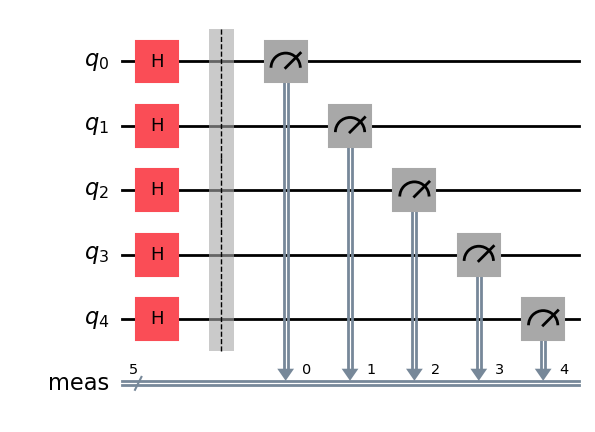

In [8]:


qc1=qk.QuantumCircuit(num_qubits,0)
qc1.h(range(num_qubits))
qc1_copy=qc1.copy()
qc1_copy.measure_all()
display(qc1_copy.draw(output='mpl'))

In [9]:
# simulamos

from qiskit.primitives import StatevectorSampler
sampler = StatevectorSampler()
job = sampler.run([qc1_copy], shots = corridas)
result = job.result()
result_data = result[0].data
data_as_bitstrings = result_data.meas.get_bitstrings()
cuantosMuestro=min(corridas,10) # no mas de diez, por si se queda muy largo
data_as_bitstrings[-cuantosMuestro:]

['00110',
 '01010',
 '01110',
 '00001',
 '10010',
 '00101',
 '00101',
 '01000',
 '01101',
 '01000']

In [4]:
result_data.meas

BitArray(<shape=(), num_shots=30, num_bits=5>)

---
# sección 2-  simulación con CuPy/GPU


Implementamos nuestro  simulador (prueba de concepto) usando CuPy para acelerar las operaciones matriciales en GPU.
1. **Carga del circuito como matriz**: Convertimos el circuito cuántico a su representación matricial usando `qk.quantum_info.Operator.from_circuit()` y lo pasamos a la GPU con `cupy.array()`. Para 5 qubits es una matriz de 32x32 complejos (complex128)

2. **Estado inicial**: Construimos $\ket{0...0}$ usando producto tensorial (`cupy.kron()`).

3. **Evolución del estado**: $\ket{ψ_{out}} = U\ket{ψ_{in}}$.  trabajo ideal para hacer directamente en la GPU, suponiendo que la memoria global es suficiente. El Offloading a GPU evita transferencias $CPU <-> GPU$.  El problema  circuitos grandes crece exponencialmente (2^n × 2^n complejos). Un circuito de 20 qubits ya requiere ~17GB solo para la matriz U.


ATENCIÓN: la sección 2 no funciona si no hay GPU disponible. Da el siguiente error:
```shell
ImplementedError: ERROR: simpuGPU* debe correr en un entorno con CUDA
```



## estado |+....+> con simuGPU

Se corre una primera simulación con el circuito |+....+>, con la funcion `simuGPU.outstate_calculate()`, que usa `cupy.matmul()` y se muestra el resultado.


In [5]:
#TODO: si simu.cupy_enabled en falso, saltea la sección
if "qc1" not in globals().keys():
    msg="ERROR: corriste la sección2? para instanciar simu* necesitamos un circuito cargado en qiskit, simulable"
    raise ValueError(msg)

In [6]:
# instanciamos el simulador para GPU en `cp33simu` con el circuito a simular
#
# esta implementacion de `outstate_calculate()` usa CuPY a "alto nivel", ver `cp33simu.simuGPUbajo()`

simu=cp33simu.simuGPU(qc=qc1)

if simu.validate_cupy() != True:
    # cancelamos, necesitamos GPU si-o-si
    msg="ERROR: simpuGPU* debe correr en un entorno con CUDA"
    print(f"ERROR: {msg}")
    raise NotImplementedError(msg)


# otras opciones NO IMPLEMENTADAS:
#simu=cp33simu.simuGPUbajo(qc=qc1)
#simu=cp33simu.simuMPI(qc=qc1)

DEBUG: Versión de CuPy: 13.6.0, GPU: b'NVIDIA GeForce GTX 960M'
INFO: Hola Mundo - Array: [1 2 3 4 5]
DEBUG: Ejecutando benchmark (multiplicación de matrices 10000x10000)...
INFO: Benchmark completado en 1492.85 ms
DEBUG: GPU.compute_capability: 50
INFO: **cupy** funciona bien, v13.6.0
INFO: Simulador creado: circuit-47
INFO: Qbits  5
INFO: Hola Mundo - Array: [1 2 3 4 5]
DEBUG: Ejecutando benchmark (multiplicación de matrices 10000x10000)...
INFO: Benchmark completado en 1489.37 ms
DEBUG: GPU.compute_capability: 50


In [7]:
# saca la matriz desde qiskit
# para preparar |+...+> la mariz del circuito será (H|0⟩)⊗...⊗(H|0⟩)
#
simu.qc_matrix=None
resultOK=simu.qc_matrix_load() #carga la matriz del circuito en la GPU
#resultOK=False
if resultOK:
    pass #TODO: mostramos matriz?
else:
    msg="no se pudo cargar la matriz del circuito"
    print(f"ERROR: {msg}")
    raise ValueError(msg)

# preparamos el estado inicial
simu.instate_matrix=None
resultOK=simu.instate_matrix_load()
if not resultOK:
    msg="ERROR: no se pudo cargar el estado de entrada"
    raise ValueError(msg)


INFO: Estado inicial cargado: [[ 0.1767767+0.j  0.1767767+0.j  0.1767767+0.j ...  0.1767767+0.j
   0.1767767+0.j  0.1767767+0.j]
 [ 0.1767767+0.j -0.1767767+0.j  0.1767767+0.j ... -0.1767767+0.j
   0.1767767+0.j -0.1767767+0.j]
 [ 0.1767767+0.j  0.1767767+0.j -0.1767767+0.j ...  0.1767767+0.j
  -0.1767767+0.j -0.1767767+0.j]
 ...
 [ 0.1767767+0.j -0.1767767+0.j  0.1767767+0.j ...  0.1767767+0.j
  -0.1767767+0.j  0.1767767+0.j]
 [ 0.1767767+0.j  0.1767767+0.j -0.1767767+0.j ... -0.1767767+0.j
   0.1767767+0.j  0.1767767+0.j]
 [ 0.1767767+0.j -0.1767767+0.j -0.1767767+0.j ...  0.1767767+0.j
   0.1767767+0.j -0.1767767+0.j]]
INFO: Estado inicial cargado
DEBUG: Estado inicial: [[1.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j

In [8]:

#todo listo, simulamos!
resultOK=simu.outstate_calculate()

INFO: estado de salida OK
DEBUG: estado de salida: [[0.1767767+0.j]
 [0.1767767+0.j]
 [0.1767767+0.j]
 [0.1767767+0.j]
 [0.1767767+0.j]
 [0.1767767+0.j]
 [0.1767767+0.j]
 [0.1767767+0.j]
 [0.1767767+0.j]
 [0.1767767+0.j]
 [0.1767767+0.j]
 [0.1767767+0.j]
 [0.1767767+0.j]
 [0.1767767+0.j]
 [0.1767767+0.j]
 [0.1767767+0.j]
 [0.1767767+0.j]
 [0.1767767+0.j]
 [0.1767767+0.j]
 [0.1767767+0.j]
 [0.1767767+0.j]
 [0.1767767+0.j]
 [0.1767767+0.j]
 [0.1767767+0.j]
 [0.1767767+0.j]
 [0.1767767+0.j]
 [0.1767767+0.j]
 [0.1767767+0.j]
 [0.1767767+0.j]
 [0.1767767+0.j]
 [0.1767767+0.j]
 [0.1767767+0.j]]


In [9]:

if not resultOK:
    print("ERROR: no se pudo calcular el estado de salida")
else:
    print(f"INFO: estado de salida OK, primeras filas: \n {simu.outstate_matrix[-cuantosMuestro:]}")

INFO: estado de salida OK, primeras filas: 
 [[0.1767767+0.j]
 [0.1767767+0.j]
 [0.1767767+0.j]
 [0.1767767+0.j]
 [0.1767767+0.j]
 [0.1767767+0.j]
 [0.1767767+0.j]
 [0.1767767+0.j]
 [0.1767767+0.j]
 [0.1767767+0.j]]


## estado |+....+> con simuGPUbajo (kernels CUDA)

Misma simulación pero usando kernels CUDA de bajo nivel en vez de las operaciones de alto nivel de CuPy.

In [33]:
# instanciamos el simulador para GPU en `cp33simu` con el circuito a simular
#
# este usa CuPy a "bajo nivel", con kernels CUDA

simu=cp33simu.simuGPUbajo(qc=qc1)

if simu.validate_cupy() != True:
    # cancelamos, necesitamos GPU si-o-si
    msg="ERROR: simpuGPU* debe correr en un entorno con CUDA"
    print(f"ERROR: {msg}")
    raise NotImplementedError(msg)


INFO: Hola Mundo - Array: [1 2 3 4 5]
DEBUG: Ejecutando benchmark (multiplicación de matrices 10000x10000)...
INFO: Benchmark completado en 1496.41 ms
DEBUG: GPU.compute_capability: 50
INFO: Hola Mundo - Array: [1 2 3 4 5]
DEBUG: Ejecutando benchmark (multiplicación de matrices 10000x10000)...
INFO: Benchmark completado en 1494.58 ms
DEBUG: GPU.compute_capability: 50
INFO: **cupy** funciona bien, v13.6.0
INFO: Simulador creado: circuit-47
INFO: Qbits  5
INFO: Simulador GPU bajo creado: circuit-47 - Qbits  5
INFO: Hola Mundo - Array: [1 2 3 4 5]
DEBUG: Ejecutando benchmark (multiplicación de matrices 10000x10000)...
INFO: Benchmark completado en 1482.23 ms
DEBUG: GPU.compute_capability: 50


In [34]:
# saca la matriz desde qiskit
# para preparar |+...+> la matriz del circuito será (H|0⟩)⊗...⊗(H|0⟩)
#
simu.qc_matrix=None
resultOK=simu.qc_matrix_load() #carga la matriz del circuito en la GPU
#resultOK=False
if resultOK:
    pass #TODO: mostramos matriz?
else:
    msg="no se pudo cargar la matriz del circuito"
    print(f"ERROR: {msg}")
    raise ValueError(msg)

# preparamos el estado inicial
simu.instate_matrix=None
resultOK=simu.instate_matrix_load()
if not resultOK:
    msg="ERROR: no se pudo cargar el estado de entrada"
    raise ValueError(msg)


INFO: Estado inicial cargado: [[ 0.1767767+0.j  0.1767767+0.j  0.1767767+0.j ...  0.1767767+0.j
   0.1767767+0.j  0.1767767+0.j]
 [ 0.1767767+0.j -0.1767767+0.j  0.1767767+0.j ... -0.1767767+0.j
   0.1767767+0.j -0.1767767+0.j]
 [ 0.1767767+0.j  0.1767767+0.j -0.1767767+0.j ...  0.1767767+0.j
  -0.1767767+0.j -0.1767767+0.j]
 ...
 [ 0.1767767+0.j -0.1767767+0.j  0.1767767+0.j ...  0.1767767+0.j
  -0.1767767+0.j  0.1767767+0.j]
 [ 0.1767767+0.j  0.1767767+0.j -0.1767767+0.j ... -0.1767767+0.j
   0.1767767+0.j  0.1767767+0.j]
 [ 0.1767767+0.j -0.1767767+0.j -0.1767767+0.j ...  0.1767767+0.j
   0.1767767+0.j -0.1767767+0.j]]
INFO: Estado inicial cargado
DEBUG: Estado inicial: [[1.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j

In [38]:
resultOK=False
#todo listo, simulamos!
#resultOK=simu.outstate_calculate()
#
resultOK=simu.outstate_calculate() #no funciona todavía
#

WARN: <class 'cp33simu.simuGPUbajo'>.GPUtopology es stub
WARN: <class 'cp33simu.simuGPUbajo'>.GPUtopology es stub
WARN: <class 'cp33simu.simuGPUbajo'>.GPUtopology es stub
INFO: estado de salida OK (kernel CUDA bajo nivel)
DEBUG: estado de salida: [0.17677669+0.j 0.17677669+0.j 0.17677669+0.j 0.17677669+0.j
 0.17677669+0.j 0.17677669+0.j 0.17677669+0.j 0.17677669+0.j
 0.17677669+0.j 0.17677669+0.j 0.17677669+0.j 0.17677669+0.j
 0.17677669+0.j 0.17677669+0.j 0.17677669+0.j 0.17677669+0.j
 0.17677669+0.j 0.17677669+0.j 0.17677669+0.j 0.17677669+0.j
 0.17677669+0.j 0.17677669+0.j 0.17677669+0.j 0.17677669+0.j
 0.17677669+0.j 0.17677669+0.j 0.17677669+0.j 0.17677669+0.j
 0.17677669+0.j 0.17677669+0.j 0.17677669+0.j 0.17677669+0.j]

INFO: estado de salida - amplitud de probabilidad de los 32 posibles estados:
|00000>: 0.177 + i0.000
|00001>: 0.177 + i0.000
|00010>: 0.177 + i0.000
|00011>: 0.177 + i0.000
|00100>: 0.177 + i0.000
|00101>: 0.177 + i0.000
|00110>: 0.177 + i0.000
|00111>: 0.177 + 

In [37]:

if not resultOK:
    print("ERROR: no se pudo calcular el estado de salida")
else:
    print(f"INFO: estado de salida OK, primeras filas: \n {simu.outstate_matrix[-cuantosMuestro:]}")

INFO: estado de salida OK, primeras filas: 
 [0.17677669+0.j 0.17677669+0.j 0.17677669+0.j 0.17677669+0.j
 0.17677669+0.j 0.17677669+0.j 0.17677669+0.j 0.17677669+0.j
 0.17677669+0.j 0.17677669+0.j]


la salida esperada para 5qbits:
```bash
INFO: estado de salida - amplitud de probabilidad de los 32 posibles estados:
|00000>: 0.177 + i0.000
|00001>: 0.177 + i0.000
|00010>: 0.177 + i0.000
...
|11101>: 0.177 + i0.000
|11110>: 0.177 + i0.000
|11111>: 0.177 + i0.000
```


---
# sección 3 - Vector de Estados distribuído con MPI


Usamos `mpi4py` para distribuir el vector de estado entre múltiples procesos (potencialmente en diferentes nodos de un cluster).  Cada proceso MPI maneja una porción del vector. Las compuertas multi-qbit requieren comunicación entre procesos cuando hay entrelazamiento , se espera ver ventajas con MPI versus GPU aisladas.

El repo incluye un script es para validar que el stack MPI (mpi4py) está instalado # y funcionando correctamente. Prueba comunicación básica entre procesos usando la clase `cp33simu.simuMPI`.  Uso (desde shell):

```shell
conda activate env_mpi #donde env_mpi es el entorno de conda con mpi4py
mpiexec -n 2 python -m mpi4py simuMPI_test.py
```
la salida debe ser (se recortan algunas líneas):

```shell
WARN: cupy no está instalado, las simulaciones van a correr en CPU
INFO: **numpy** funciona bien, v1.26.4
INFO: Simulador MPI creado: circuit-46
INFO: Qbits  1
INFO: Simulador MPI creado: circuit-46
INFO: Qbits  1
Received: [0.+0.j 1.+0.j 2.+0.j 3.+0.j 4.+0.j 5.+0.j 6.+0.j 7.+0.j 8.+0.j 9.+0.j]
```


Si está habilitado el benchmark (se pasó un dict con el par "simuMPI":True), se verá algo como eso a la salida:

```bash
INFO: Benchmark completado en 106.44 ms
DEBUG: simu.benchmark: {''clase': 'simuMPI', 'walltime': 106.4397080008348}
```


In [13]:
# le meto los datos de simu.benchmark a mano...

_=pd.DataFrame(columns=["clase","corrida","circuito","num_qubits","walltime"],
               data=[["simuMPI","1",qc1.name,qc1.num_qubits,106.4397080008348],])
display(_)
benchmarks_corridos = pd.concat([benchmarks_corridos, _], ignore_index=True)



,clase,corrida,circuito,n_qubits,walltime
0,simuMPI,1,circuit-48,5,106.439708


In [14]:
benchmarks_corridos

,clase,circuito,corrida,n_qubits,walltime
0,simuMPI,circuit-48,1,5,106.439708
1,simuMPI,circuit-48,1,5,106.439708
2,simuMPI,circuit-48,1,5,106.439708
3,simuMPI,circuit-48,1,5,106.439708
4,simuMPI,circuit-48,1,5,106.439708


## estado |+....+> con MPI (send/recv y bcast)

para la simulacion del estado ejecutar `simuMPI.py` con tantas procesos como 2**qubits, por ejemplo:

```bash
conda activate env_mpi #donde env_mpi es el entorno
mpiexec -n 32 python -m mpi4py simuMPI.py # para 5qb
```
```bash
conda activate env_mpi #donde env_mpi es el entorno
mpiexec -n 1024 python -m mpi4py simuMPI.py # para 10qb
```
la documentación habla de un modificador `--oversubscribe` que no parece necesario.
la salida será algo como lo siguiente, repetido $2^{qb}$ veces, es decir una por cada fila de la matriz del circuito:

```bash
WARN: cupy no está instalado, las simulaciones van a correr en CPU
INFO: **numpy** funciona bien, v1.26.4
INFO: Simulador creado: circuit-46
INFO: Qbits  5
```
eso se debió a que el estado de salida $U\ket{\phi}$ se logra con la multiplicacion de `simuMPI.qc_mztrix` con el vector de estado `simuMPI.instate_matrix`.
Para eso reparte el vector entrada, una vez `MPI.bcast` entre los procesos, pero habrá uno de ellos por cada fila de la matriz del circuito (menos uno, ya que el root hace la fila0).

```bash
DEBUG:  Outstate: [0.1767767+0.j 0.1767767+0.j 0.1767767+0.j 0.1767767+0.j 0.1767767+0.j
 0.1767767+0.j 0.1767767+0.j 0.1767767+0.j 0.1767767+0.j 0.1767767+0.j
...
```
 la salida esperada para 5qbits es:

```bash
INFO: Estado de salida - amplitud de probabilidad de los 32   posibles estados::
|00000>: 0.177 +i0.000
|00001>: 0.177 +i0.000
|00010>: 0.177 +i0.000
...
|11101>: 0.177 +i0.000
|11110>: 0.177 +i0.000
|11111>: 0.177 +i0.000
```

---
# sección 4 - conclusiones





#### sobre la Sección 0: Inicialización del entorno y variables globales

Se valida que el stack está instalado y funcionando, distinguiendo entre entorno con CUDA(cupy/GPU) y sin CUDA (solo para MPI).
En el primer caso se lee:"INFO: **cupy** funciona bien, v13.6.0" y en el segundo "INFO: **numpy** funciona bien, v".

Para el desarrollar con el stack con CuPY, se usó una GTX 960M (compute capability 5.0) local, y sirvió bien como PoC. El benchmark de multiplicación de matrices 10000x10000 en ~1.5 segundos parece razonable.

##### `cc33simu`

el diseño sirvió: Separar la interfaz de la implementación nos permite comparar diferentes estrategias de HPC (GPU alto nivel, GPU bajo nivel, MPI distribuido) usando la misma API.



#### sobre la Sección 1: Estado |+....+> con qiskit-aer

Acá usamos el `StatevectorSampler` de Qiskit para simular el estado de máxima superposición. Es  la referencia contra la cual vamos a comparar nuestro simulador. 30 corridas nos dan un sampling decente del espacio de estados - todos los bitstrings salen con probabilidad uniforme, se espera a la salida de la compuerta Hadamard H|0> da |+>. El `StatevectorSampler` es la forma "oficial" de hacer esto en Qiskit.

#### sobre la Sección 2: Simulación con CuPy/GPU

 DEmostramos que se puede  simular usando CuPy. El resultado muestra todas las amplitudes en √(1/32) ≈ 0.177, que es lo esperado para el estado |+...+⟩. Matemáticamente correcto, y acelerando con GPU.
 Se implementó un kernel de bajo nivel para CuPy, reemplazando `cupy.matmul()`.


#### sobre la Sección 3: Vector de Estados distribuido con MPI

Se implementó descomposición de dominio del statevector usando MPI para superar limitaciones de memoria de un solo nodo.


El script de prueba `simuMPI_test.py` valida comunicación MPI entre procesos, considerando el tipo de datos MPI_Datatype que mapee bien a un tipo de dato de CuPy/NumPy.
El script principal de esta sección: `simuMPI_test.py` valida la proclama de CuPY, como "drop-in replacement" de Numpy.

Se logró simular estado |+....+>, ahora el método `oòutstate_calculate()` no está implementado, se corre directamente en  `simuMPI.py`.  Para la simulacion del estado ejecutar `simuMPI.py` con tantas procesos como 2**qubits, por ejemplo:

```bash
#shell, no jupyter notebook
conda activate env_mpi #donde env_mpi es el entorno
mpiexec -n 32 python -m mpi4py simuMPI.py # para 5qb
```
La salida tiene la forma: `|00000>: 0.17678` que es la probabilidad de obtener cada estado durante la medición final. Se probó con hasta 5 qbits, pero por encima da el error "Too many open files":

```bash
HYDU_create_process (lib/utils/launch.c:24): pipe error (Too many open files)
```

#### Infraestructura

- **Google Colab**: Intentamos usar Colab pero no funcionó. Probablemente por restricciones en el runtime o versiones incompatibles de CUDA/CuPy.

- **Notebook local con GPU**: Terminamos instalando CUDA y CuPy en una máquina local con una GPU geforce GTX 960M

A veces la infraestructura "gratis" de la nube no es tan flexible como tu propio HW donde hay control total del stack.

##### Trabajo Futuro

- [ ] benmarks entre las distintas implementaciones. No se espera q sea absoluto, ya que simuGPU corre en un entorno con CUDA y HW de NVDIA, y simuMPI en el entorno de desarrollo del resto de la biblioteca `simuCP33`.
- [ ] Estudiar la posiblidad de incorporar benchmarks "absolutos" a la API.
